<a href="https://colab.research.google.com/github/VoKisnaHai1102/Frames-to-Fables/blob/main/Assignment%205/240563_KrishnaAg_assgn5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment 5

This assignment is designed to help you understand, implement, and get hold of two important models in Multi-Modal Learning: CLIP and BLIP.

Before starting to code, read the instructions and comments carefully. Make sure you understand the requirements and the expected output.

There are two parts of this assignment.
- Content based image retrieval (CBIR) based on CLIP
- Visual Question Answering (VQA) based on BLIP

## Part 1: Content Based Image Retrieval (CBIR)

Ever found yourself looking for a specific image in a load of photos on your phone?
Imagine you have a system that can retrieve images based on their content. In this assignment, you will implement exactly that.

### Task
1. I have provided a list of images in form of unsplash links. Feel free to explore and add more images.
2. You will have to implement CBIR system that will retrive images based on the query you provide.
3. You have to use CLIP model to extract image and text embeddings. Since CLIP projects both image and text into the same embedding space, similar images and their corresponding text descriptions will be close to each other in the embedding space.
4. You have to use a pretrained CLIP model from HuggingFace. (Because it is not feasible to train CLIP from scratch)
5. You have to use [OpenAI's CLIP](https://huggingface.co/openai/clip-vit-base-patch32) model from HuggingFace. Refer to the page itself and anyother resources you find useful, on how to use it.
6. You will have to take an input query from user, and display the best image matching the query. (You can use cosine similarity to find similarity between the query and the images, then display the image with highest similarity score)

##### Load all the libraries

In [38]:
## Load libraries
!pip install -q pillow torch requests transformers
import requests
from PIL import Image
from io import BytesIO
import os
import torch
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt

IMAGE_URLS = [
    "https://images.unsplash.com/photo-1750126833705-ba98013f16f3",
    "https://images.unsplash.com/photo-1749627995669-4d4dda3a9c1d",
    "https://images.unsplash.com/photo-1744294724362-3f5c404c771a",
    "https://images.unsplash.com/photo-1750075750236-3f8924fc0e35"
]

os.makedirs("images", exist_ok=True)

for i, url in enumerate(IMAGE_URLS):
    response = requests.get(url)
    if response.status_code == 200:
        image = Image.open(BytesIO(response.content))
        image.save(f"images/image_{i+1}.jpg")
    else:
        print(f"Failed to download image from {url}")


# Load image paths
folder_path="/content/images"
image_files = os.listdir(folder_path)
image_paths = [os.path.join(folder_path, filename) for filename in image_files]
# Feel free to edit the above list with your own image URLs

##### Load the CLIP model

In [39]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

##### Loop through images, convert then to tensors, and store them in a list

In [40]:
image_tensors = []
for image_path in image_paths:
  image = Image.open(image_path)
  inputs = processor(images=image, return_tensors="pt")
  image_tensors.append(inputs.pixel_values)

##### Get the embeddings for the images and store them in a list
Use the CLIP model linked above, the page also provides details on how to use it. If you have any issues with it, feel free to use anyother resources you find useful.

In [42]:
image_embeddings = []

for image_tensor in image_tensors:

    with torch.no_grad():
        image_features = model.get_image_features(pixel_values=image_tensor)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    image_embeddings.append(image_features)

# Stacking embeddings into one tensor
image_embeddings_tensor = torch.vstack(image_embeddings)

##### Get the query from user

In [43]:
query = input("Enter which image are you looking for: ")

Enter which image are you looking for:  hands with a camera


##### Get the embeddings for the user query

In [44]:
text_inputs = processor(text=[query], return_tensors="pt", padding=True)

with torch.no_grad():
    # Getting text features
    text_embeddings = model.get_text_features(**text_inputs)
    # Normalizing the text features
    text_features = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)

##### Find the similarity between the query and all the images

In [45]:
cosine_similarity = torch.matmul(text_features, image_embeddings_tensor.T)
scores = cosine_similarity.squeeze(0).tolist()

##### Display the image with highest similarity score

Best matching image: /content/images/image_3.jpg


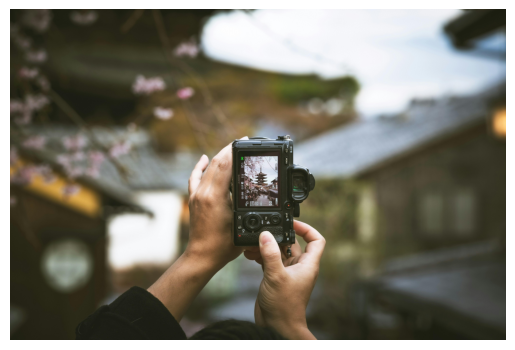

In [46]:


best_image_index = scores.index(max(scores))
best_image_path = image_paths[best_image_index]

print(f"Best matching image: {best_image_path}")
best_image = Image.open(best_image_path)
plt.imshow(best_image)
plt.axis('off')
plt.show()

Congrats! You have implemented a simple Content Based Image Retrieval (CBIR) system using CLIP model.

Moving on to the next part of the assignment.

## Part 2: Visual Question Answering (VQA)

This part is based on Visual Question Answering (VQA), where you will be given an image and a question about that image, and you will need to provide an answer.

You are provided with a dataset of 10 images, and a json file containing questions and answers for those images.

### Format of JSON file
```json
[
    "what is the blue shape?",
    "rectangle",
    0
]
```
This means that the question is "what is the blue shape?", the answer is "rectangle", and the image index is 0.
Images are named from 0 to 9, so the image for index 0 is `0.png`.

### Task
1. Load the JSON file and parse the questions and answers.
2. Just for understanding, print a few questions and their corresponding answers, also display the corresponding images. (You may do it for 1 or 2 questions)
3. Implement a function that takes an image and a question, and returns the answer.
4. Run the function on all questions and store the answers in a file. (You can store it in a new JSON or CSV file) (May use pandas for this)
5. Now since you have the answers, you can also evaluate your model. For this, you can compare your answers with the ground truth answers provided in the JSON file. (refer to note below)

Note: But it is not that easy to compare directly, as the answers may not match exactly due to variations in phrasing ("2" and "two", "blue" and "The color is blue". Phrases like this don't match, but are correct). So you should check your answers manually and see if they are correct or not. Do it for first 30 answers, and calculate the accuracy.
There are certain ways to automate this, but they will make this assignment too complicated, so we will not do that here.

### Additional Points
- Refer to BLIP model that was taught in last class. It can be used to answer questions based on images.
- You will have to use pre-trained BLIP model for this task. (Because training it from scratch is not feasible in this assignment)
- You have to use [Salesforce BLIP model](https://huggingface.co/Salesforce/blip-vqa-base) for this task. Refer to the Usage section of page for details on how to use it. If you feel stuck, you can refer to blogs available online, or use AI tools to get yourself familiar with the model.

1. Load libraries, and the JSON file.

In [15]:
from google.colab import files
uploaded = files.upload()
!pip install -q transformers pillow pandas
# Loading libraries
import torch
from PIL import Image
from transformers import BlipProcessor, BlipForQuestionAnswering
import json
import matplotlib.pyplot as plt
import pandas as pd

Saving filtered_questions.json to filtered_questions (1).json


2. Display a few questions and answers along with images.

Question 2: what color is the shape?
Answer 2: blue


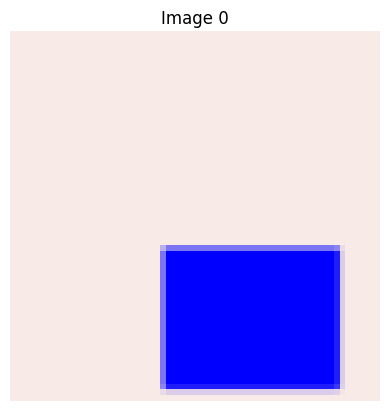

Question 3: does the image contain a rectangle?
Answer 3: yes


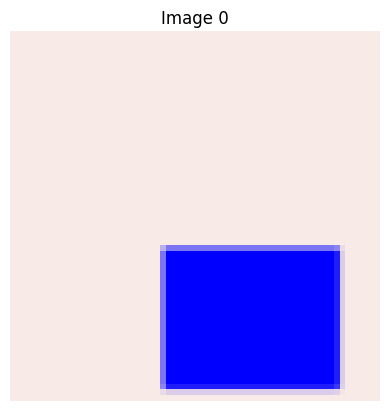

Question 4: is there a triangle in the image?
Answer 4: no


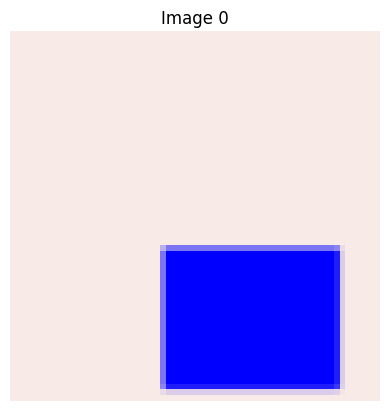

Question 5: is there a black shape?
Answer 5: no


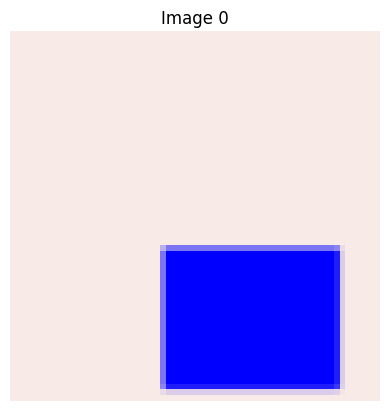

In [47]:
from google.colab import files
uploaded = files.upload()
with open("/content/filtered_questions.json") as f:
  data = json.load(f)
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")
for i in range(1,5):
    question, answer, image_idx = data[i]

    print(f"Question {i+1}: {question}")
    print(f"Answer {i+1}: {answer}")

    image_path = f"/content/{image_idx}.png"
    image = Image.open(image_path)

    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Image {image_idx}")
    plt.show()

3. Implement the function to answer questions based on images.

In [48]:
def vqa(question, image):
    raw_image = Image.open(image_path).convert("RGB")
    inputs = processor(raw_image, question, return_tensors="pt")
    out = model.generate(**inputs)
    answer = processor.decode(out[0], skip_special_tokens=True)
    return answer

4. Run the function on all questions and store the answers in a file.

In [49]:

import pandas as pd
results = []
for item in data:
    question, ground_truth, image_index = item
    image_path = f"{image_index}.png"

    try:
        image = Image.open(image_path).convert("RGB")
        predicted_answer = vqa(question, image)

        results.append({
            "image": image_path,
            "question": question,
            "ground_truth": ground_truth,
            "predicted_answer": predicted_answer
        })

    except Exception as e:
        print(f"Error with image {image_path}: {e}")

df = pd.DataFrame(results)
df.to_csv("vqa_predictions.csv", index=False)

5. Evaluate the model by comparing answers with ground truth.
Do the comparison manually for the first 30 answers and print the accuracy.

In [50]:
print("First 30 Predictions:\n")
correct = 0

for i, r in enumerate(results[:30]):
    print(f"{i+1}. Q: {r['question']}")
    print(f"   Ground Truth:      {r['ground_truth']}")
    print(f"   Predicted Answer:  {r['predicted_answer']}")
    if r['ground_truth'] == r['predicted_answer']:
        correct += 1
    print("-" * 50)

print(f"\nAccuracy: {(correct/30)*100}")

First 30 Predictions:

1. Q: what is the blue shape?
   Ground Truth:      rectangle
   Predicted Answer:  rectangle
--------------------------------------------------
2. Q: what color is the shape?
   Ground Truth:      blue
   Predicted Answer:  black
--------------------------------------------------
3. Q: does the image contain a rectangle?
   Ground Truth:      yes
   Predicted Answer:  yes
--------------------------------------------------
4. Q: is there a triangle in the image?
   Ground Truth:      no
   Predicted Answer:  no
--------------------------------------------------
5. Q: is there a black shape?
   Ground Truth:      no
   Predicted Answer:  yes
--------------------------------------------------
6. Q: does the image not contain a gray shape?
   Ground Truth:      yes
   Predicted Answer:  yes
--------------------------------------------------
7. Q: is there a red shape in the image?
   Ground Truth:      no
   Predicted Answer:  no
------------------------------------

Bonus: This images were too simple. But guess what? Salesforce has pretrained it's model on wide variety of images, so you can use it on any image of your choice.

Try to load any real world image of any natural scene, or anything you like, and ask questions about it. You will be surprised by the results.

In [51]:
def ask_question_about_image(image_path, question):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(image, question, return_tensors="pt")
    output = model.generate(**inputs)
    answer = processor.decode(output[0], skip_special_tokens=True)
    return answer
image_path = "/content/images/image_1.jpg"
question ="What is the colour of water?"

answer = ask_question_about_image(image_path, question)
print(f"Q: {question}")
print(f"A: {answer}")

Q: What is the colour of water?
A: green


The End 🫡.

If you have any questions, feel free to use following in the given order:
- Google it!!
- ChatGPT
- Ask on the group